##### Figure 1: per-chromosome and whole genome PCA
##### Figure S2: skree plot

In [1]:
from collections import defaultdict
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import allel
import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

In [3]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

In [4]:
chroms_dict = defaultdict(dict)

countries = ["Brazil", "Colombia", "USA", "Gabon", "Kenya", "Senegal"]
chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]

for chrom in chroms:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_1 (18443972, 131, 2)
AaegL5_2 (32930875, 131, 2)
AaegL5_3 (27660249, 131, 2)


In [5]:
np.sum([chroms_dict[chrom]["gt"].shape[0] for chrom in chroms])

79035096

##### read in the metadata

In [6]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t")

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


In [7]:
np.sum(~(md["sample_id"] == samples.compute()))

0

##### remove close kin

In [8]:
to_drop = np.loadtxt(
    md_path + "close_kin_removed_new_dataset.txt", dtype="str")

to_drop

array(['SRR11006849', 'SRR11006846', 'SRR6768018', 'FEMALE_17',
       'FEMALE_22', 'SRR11006674', 'SRR11006683', 'SRR11006754'],
      dtype='<U11')

In [9]:
to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [10]:
md_filtered = md.loc[to_drop_bool]

md_filtered.shape

(123, 8)

##### read in the positions of poorly mappable and repetitive regions

In [11]:
mask = pd.read_table(
    base_path + "refs/aegy/unified_mask/merged_rep_map_masks.110822.bed",
sep="\t", names=["chrom", "start", "end"])

mask.head()

,chrom,start,end
0,AaegL5_1,0,273
1,AaegL5_1,297,373
2,AaegL5_1,413,7449
3,AaegL5_1,7452,8789
4,AaegL5_1,9854,18833


##### figure 1

In [12]:
outString = ingenos.make_date_stamp(results_path + \
                                    "popgen/PCA_2x2_with_labels", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/popgen/PCA_2x2_with_labels.020823.pdf'

<ipython-input-13-a5a342d91c88>:22: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq_flt = chroms_dict[chrom]["gq"]\


AaegL5_1


<ipython-input-13-a5a342d91c88>:22: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq_flt = chroms_dict[chrom]["gq"]\


AaegL5_2


<ipython-input-13-a5a342d91c88>:22: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  gq_flt = chroms_dict[chrom]["gq"]\


AaegL5_3


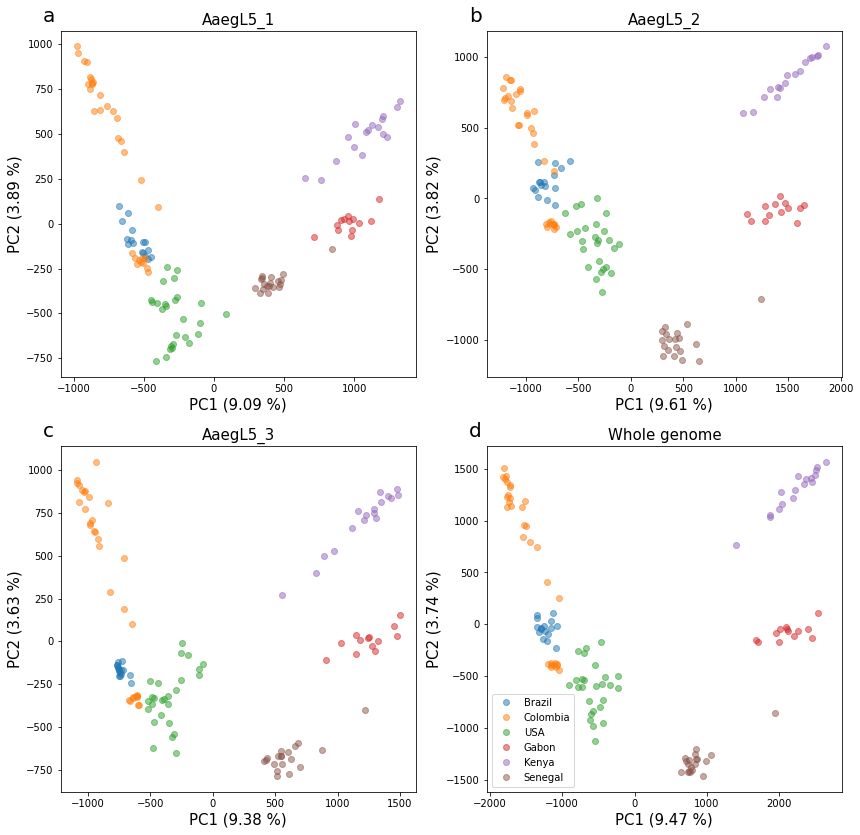

In [13]:
by_chrom_alts = []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

for i, chrom in enumerate(chroms):
    
    ax = axes.flatten()[i]
    pos = allel.SortedIndex(chroms_dict[chrom]["pos"])
    gt = chroms_dict[chrom]["gt"]
    
    chrom_mask = mask[mask["chrom"] == chrom]
    
    ##drop low-quality and repetitive regions for each chrom
    mask_flt = (~(pos.locate_ranges(chrom_mask["start"] + 1, 
                                          chrom_mask["end"],
                                          strict=False)))
        
    gt_flt = allel.GenotypeArray(gt).subset(sel0 = mask_flt,
                                            sel1 = to_drop_bool)
    
    ##mask genotypes with qualities below 20
    gq_flt = chroms_dict[chrom]["gq"]\
    [:, to_drop_bool]\
    [mask_flt, :].compute()
    
    gt_flt.mask = gq_flt < 20
    
    allele_counts = allel.AlleleCountsArray(gt_flt.count_alleles())
    
    allele_counts_boolean = (allele_counts.max_allele() <= 2) &\
    (allele_counts[:, :2].min(axis=1) > 1) & (
        allele_counts.to_frequencies()[:,1] > 0.05)

    n_alts = gt_flt.subset(sel0 = allele_counts_boolean).to_n_alt()
    
    by_chrom_alts.append(n_alts)

    coords, model = allel.pca(n_alts)

    x = coords[:, 0]
    y = coords[:, 1]

    for country in countries:

        flt = md_filtered["country"] == country

        ax.plot(x[flt], y[flt], linestyle = ' ', marker = "o", label=country,
               alpha = 0.5)

    ax.set_xlabel(f"PC1 ({round(model.explained_variance_ratio_[0]*100, 2)} %)", fontsize=15)
    ax.set_ylabel(f"PC2 ({round(model.explained_variance_ratio_[1]*100, 2)} %)", fontsize=15)

    ax.set_title(chrom, fontsize=15)
    print(chrom)
    
##finally, add the whole-genome PCA
ax = axes.flatten()[-1]

all_alts = np.concatenate(by_chrom_alts)

coords, model = allel.pca(all_alts)

x = coords[:, 0]
y = coords[:, 1]

for country in countries:

    flt = md_filtered["country"] == country

    ax.plot(x[flt], y[flt], linestyle = ' ', marker = "o", label=country,
           alpha = 0.5)

ax.set_xlabel(f"PC1 ({round(model.explained_variance_ratio_[0]*100, 2)} %)", fontsize=15)
ax.set_ylabel(f"PC2 ({round(model.explained_variance_ratio_[1]*100, 2)} %)", fontsize=15)

ax.set_title("Whole genome", fontsize=15)

ax.legend()

##label each panel
for i, ax in enumerate(axes.flatten()):
    label = ["a","b","c","d"][i]
    ax.text(x=-0.05, y=1.025, s=label, transform=ax.transAxes, fontsize=20)

#plt.savefig(outString, bbox_inches="tight")

##### total sites used:

In [14]:
len(all_alts)

9341399

##### add the skree plot for the whole genome panel (d)

In [15]:
outString = ingenos.make_date_stamp(results_path + \
                                    "popgen/whole_genome_PCA_scree_plot", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/popgen/whole_genome_PCA_scree_plot.020823.pdf'

Text(0, 0.5, '% variance explained')

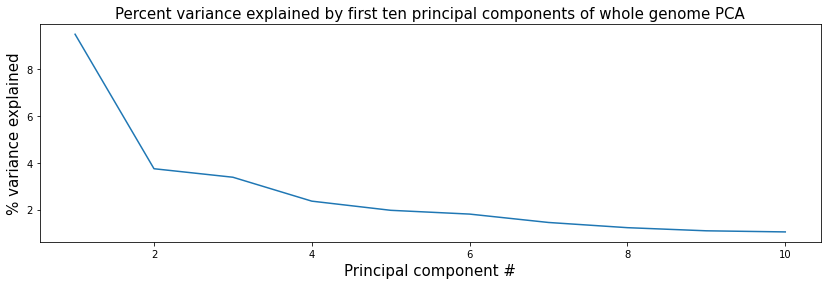

In [16]:
fig, ax = plt.subplots(figsize=(14,4))

ax.plot(range(1,11), model.explained_variance_ratio_ * 100)

ax.set_title("Percent variance explained by first ten principal components of whole genome PCA", 
             fontsize=15)
    
ax.set_xlabel("Principal component #", fontsize=15)
ax.set_ylabel("% variance explained", fontsize=15)

#plt.savefig(outString, bbox_inches="tight")